In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from joblib import dump
import numpy as np

folder_path = r'C:\Users\abhir\OneDrive\Documents\college\sem 7\cyber_assign\passwords'
all_files = os.listdir(folder_path)

df_list = []
for file in all_files:
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

def count_to_strength(count):
    if count == 0:
        return 100  
    elif count > 100:
        return 1  
    else:
        return max(1, 100 - count)

df['strength_percentage'] = df['count'].apply(count_to_strength)

hash_encoder = LabelEncoder()
df['hash_encoded'] = hash_encoder.fit_transform(df['hash'])

df_sampled = df.sample(frac=0.1, random_state=42) 
X_sampled = df_sampled[['hash_encoded', 'count']]
y_sampled = df_sampled['strength_percentage']

X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 20],       
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],  
    'bootstrap': [True]         
}

regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='neg_mean_absolute_error') 

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found by GridSearchCV: {best_params}")

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

dump(best_model, 'best_password_strength_model.joblib')
print("Best model trained and saved successfully.")


Best parameters found by GridSearchCV: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best model trained and saved successfully.


Cross-Validation MAE scores for 5 folds: [28.21156659 28.20857721 28.21630113 28.21950293 28.16992815]
Mean MAE: 28.2052
Standard Deviation of MAE: 0.0180


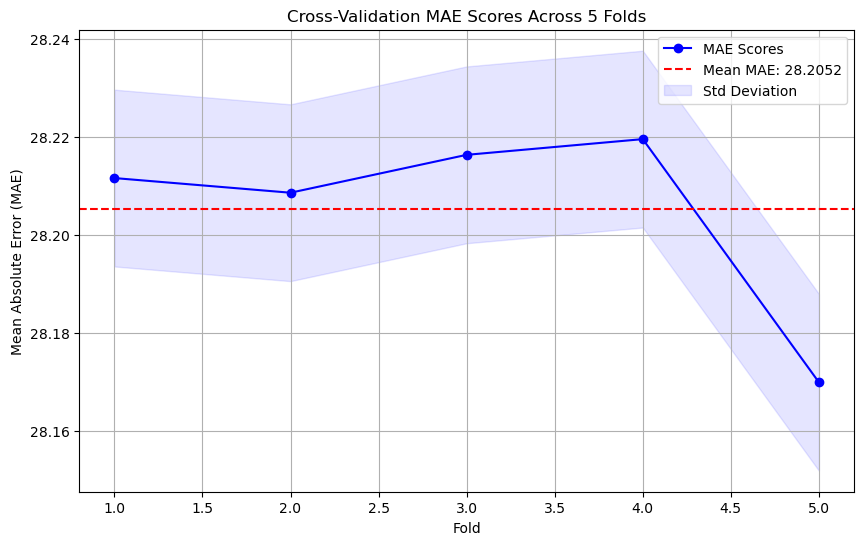

In [2]:
import pandas as pd
import numpy as np
import os  
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt  
from sklearn.linear_model import LinearRegression  

folder_path = r'C:\Users\abhir\OneDrive\Documents\college\sem 7\cyber_assign\passwords'

all_files = os.listdir(folder_path)

df_list = []
for file in all_files:
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

def count_to_strength(count):
    if count == 0:
        return 100  
    elif count > 100:
        return 1  
    else:
        return max(1, 100 - count)

df['strength_percentage'] = df['count'].apply(count_to_strength)

hash_encoder = LabelEncoder()
df['hash_encoded'] = hash_encoder.fit_transform(df['hash'])

X = df[['hash_encoded', 'count']]
y = df['strength_percentage']

regressor = LinearRegression()


k = 5  
cv_scores = cross_val_score(regressor, X, y, cv=k, scoring='neg_mean_absolute_error')

mae_scores = -cv_scores

print(f"Cross-Validation MAE scores for {k} folds: {mae_scores}")
print(f"Mean MAE: {mae_scores.mean():.4f}")
print(f"Standard Deviation of MAE: {mae_scores.std():.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, k+1), mae_scores, marker='o', linestyle='-', color='b', label='MAE Scores')
plt.axhline(y=mae_scores.mean(), color='r', linestyle='--', label=f'Mean MAE: {mae_scores.mean():.4f}')
plt.fill_between(range(1, k+1), mae_scores - mae_scores.std(), mae_scores + mae_scores.std(), color='b', alpha=0.1, label='Std Deviation')
plt.title(f'Cross-Validation MAE Scores Across {k} Folds')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import hashlib
from joblib import load
from scipy.spatial.distance import hamming

def hash_password_sha1(password):
    return hashlib.sha1(password.encode()).hexdigest().upper()

def calculate_hash_similarity(hash1, hash2):
    h1 = ''.join(format(int(c, 16), '04b') for c in hash1)
    h2 = ''.join(format(int(c, 16), '04b') for c in hash2)
    return 1 - hamming(list(h1), list(h2))

def predict_password_strength(new_password, model, hash_encoder, df, top_n=5):

    hashed_password = hash_password_sha1(new_password)
    
    similarities = df['hash'].apply(lambda x: calculate_hash_similarity(hashed_password, x))
    
    df['similarity'] = similarities
    
    most_similar_indices = df.nlargest(top_n, 'similarity').index  
    similar_passwords = df.loc[most_similar_indices, ['hash', 'similarity', 'count']]

    most_similar_hash_encoded = df.loc[most_similar_indices[0], 'hash_encoded']
    breach_count = df.loc[most_similar_indices[0], 'count']
    
    strength_percentage = model.predict([[most_similar_hash_encoded, breach_count]])[0]
    
    return strength_percentage, similar_passwords

model = load('best_password_strength_model.joblib')
print("Model loaded successfully.")

folder_path = r'C:\Users\abhir\OneDrive\Documents\college\sem 7\cyber_assign\passwords'
all_files = os.listdir(folder_path)

df_list = []
for file in all_files:
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        df_list.append(df)

df = pd.concat(df_list, ignore_index=True)

hash_encoder = LabelEncoder()
df['hash_encoded'] = hash_encoder.fit_transform(df['hash'])

new_password = "tornado0
9of"
predicted_strength, similar_passwords = predict_password_strength(new_password, model, hash_encoder, df)

print(f"Predicted password strength: {predicted_strength:.2f}%")
print("Most similar passwords:")
print(similar_passwords)


Model loaded successfully.
Predicted password strength: 1.00%
Most similar passwords:
                                            hash  similarity  count
100222  48ACA044E680F90AAA2D5321AF9AC793E084E19D     0.67500    580
638632  4E0EA18E36F32DA83ECC57BD251A87A0E521F8F5     0.67500     29
27789   439C8FD4AFABEA1EF505E630E9FBEF2AB5CFF5EB     0.66875     17
49615   592B90C0F7F4A5006F20979C2D0A3A33C46D3DE9     0.66875    147
51476   49940BB64A2BE18FA615320065D0AE14344B8F27     0.66875    101


c:\Users\abhir\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Accuracy: 95.87%
                precision    recall  f1-score   support

Normal Traffic       0.96      0.91      0.93     11169
Attack Traffic       0.96      0.98      0.97     23900

      accuracy                           0.96     35069
     macro avg       0.96      0.95      0.95     35069
  weighted avg       0.96      0.96      0.96     35069



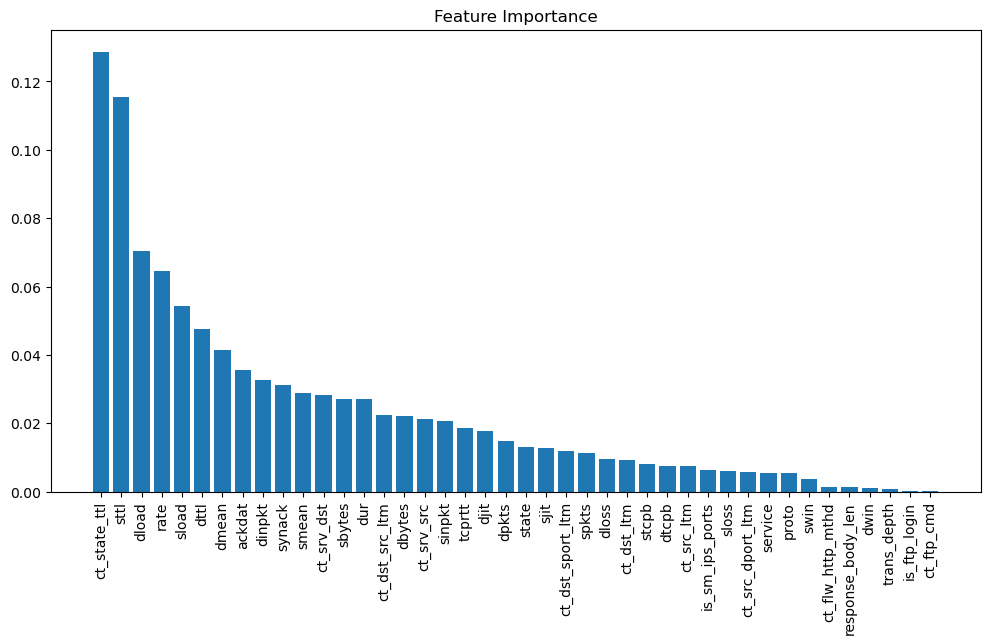

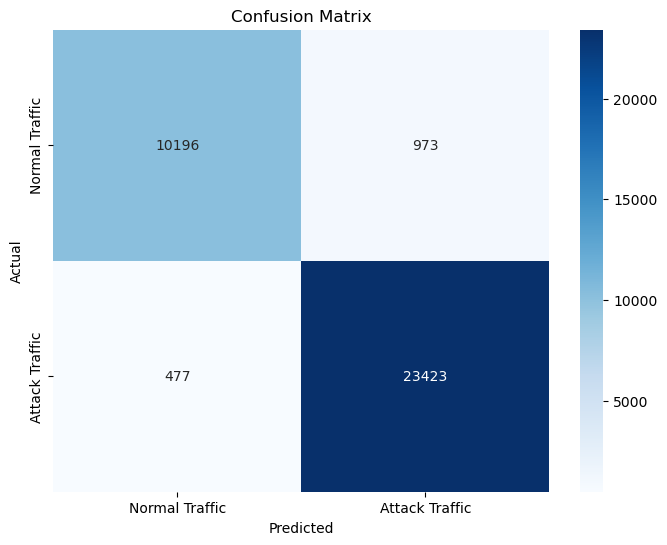

NameError: name 'y_pred_proba' is not defined

In [2]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Step 2: Load the dataset
file_path = r'C:\Users\abhir\OneDrive\Documents\college\sem 7\cyber_assign\net\Training and Testing Sets\UNSW_NB15_training-set.csv'
data = pd.read_csv(file_path)

# Step 3: Data Preprocessing
# Drop irrelevant columns like 'id' and 'attack_cat' (if 'attack_cat' is not needed for model training)
X = data.drop(['id', 'attack_cat', 'label'], axis=1)
y = data['label']  # 'label' column as target

target_names = ['Normal Traffic', 'Attack Traffic']

# Encode categorical columns like 'proto', 'service', 'state' to numerical using LabelEncoder
le = LabelEncoder()
X['proto'] = le.fit_transform(X['proto'])
X['service'] = le.fit_transform(X['service'])
X['state'] = le.fit_transform(X['state'])

# Handle any missing values if present
X.fillna(X.mean(), inplace=True)

# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = rf.predict(X_test)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
print(classification_report(y_test, y_pred, target_names=target_names))

# Optional: Feature Importance
import matplotlib.pyplot as plt
import numpy as np

feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()